In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

***Thoughts from Anna***

1. I think that when the current code is reading the parquet files it is missing with the time_of_day column. It may be dropping zeros if there is a zero in from of the int. This would lose data as 4 am would be represented by a number string starting with "04" in the %H:%M:%S.%9f format.

2. Under the assumption that problematic internet usage happens a lot at night, we could use the time_of_day column to filter for night rows. Then look at the light column. Could great a count metric for something like, number of times lux was about 300 for a 15 minutes period. 

3. Anglez is a measurement of people turning over in their sleep. Under the assumption that too much internet use causes sleep disturbances, we could figure out a threshold for what would be a considered someone turning over in bed. We could also limit the count for these during expected sleeping periods.

4. Assuming internet addiction leads to less physical movement, we could use average enmo value as an input.

***Column Variable Descriptions:***

**id** - The patient identifier corresponding to the id field in train/test.csv.

**step** - An integer timestep for each observation within a series.

**X, Y, Z** - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.

**enmo** - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

**anglez** - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.

**non-wear_flag** - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.

**light** - Measure of ambient light in lux. See ​​here for details.

**battery_voltage** - A measure of the battery voltage in mV.

**time_of_day** - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.

**weekday** - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.

**quarter** - The quarter of the year, an integer from 1 to 4.

**relative_date_PCIAT** - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

***Lux (Light) Measures:***

1 Twilight

5 Minimal Street Lighting

10 Sunset

50 Family Living Room

80 Hallway 

100 Very Dark Overcast Day 

320 - 500 Office Lighting 

400 Sunrise/Sunset 

1,000 Overcast Day 

10,000-25,000 Full Daylight 

32,000-130,000 Direct Sunlight


"The scale is somewhat proportional, meaning that each increase of one represents a ten-fold increase in brightness"



Source: https://actigraphcorp.my.site.com/support/s/article/Lux-Measurements

Screens deliver much less, according to data on 20 devices provided to Elemental by Rea at the Lighting Research Center. At full brightness in color, typical screens in your home deliver anywhere from 37.8 lux to less than one lux at normal viewing distances.

Some of Rea’s data:

Desktop computers: 0.5 to 37.8 lux

Laptop computers: 1.7 to 14.5 lux

Tablets: 0.7 to 5.9 lux

Smartphones: 0.6 to 2.1 lux

TVs: 0.03 to 0.5 lux

Source: https://elemental.medium.com/does-blue-light-from-screens-really-ruin-sleep-ae5e758c453e#:~:text=At%20full%20brightness%20in%20color,computers%3A%201.7%20to%2014.5%20lux

In [21]:
# Path to  #
data_dir = os.path.abspath(os.path.join('..', 'data'))
#"/Users/annamowat/Documents/GitHub/datasci207_fa24_01_LMRSW/data/series_train.parquet"
DATA_PATH = os.path.join(data_dir,'series_train.parquet') # replace with your path

In [22]:
def load_data(path_to_data):
    '''Load parquet data and their corresponding person ids
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    parquets (list of dataframes):

    '''
    ## load images and labels
    parquets = []
    
    for folder in os.listdir(DATA_PATH):
        if folder == ".DS_Store":
            continue
        else:
            for image in os.listdir(os.path.join(DATA_PATH,folder)):
                # Load parquet
                path = os.path.join(DATA_PATH,folder,image)
                parquet = pd.read_parquet(path) 
                parquet["id"] = folder[3:]

                # Append image and label
                parquets.append(parquet)


    return parquets

In [46]:
def convert_int_to_datetime(int_value):
    """Converts an integer representing time in the format %H:%M:%S.%f to datetime."""
    return pd.to_datetime(int_value, format="%H:%M:%S.%f")

In [23]:
parquets = load_data(DATA_PATH)

In [48]:
test = parquets[0]

In [49]:
# Convert time_of_day to a datetime column
test['time_datetime'] = test['time_of_day'].apply(convert_int_to_datetime)

ValueError: time data "57480000000000" doesn't match format "%H:%M:%S.%f", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [50]:
# First test to see if they ever took the watch off
test[test["non-wear_flag"] != 0.0]

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,id,datetime_time_of_day


In [40]:
test.head(10)

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT,id,datetime_time_of_day
0,0,0.238866,-0.740705,0.511232,0.063155,29.657835,0.0,54.666668,4177.00,41940000000000,1,2,13.0,cefdb7fe,1971-05-01 10:00:00
1,1,-0.369359,-0.541653,0.498858,0.090516,32.655003,0.0,71.000000,4176.75,41945000000000,1,2,13.0,cefdb7fe,1971-05-01 11:23:20
2,2,-0.172721,-0.042719,0.928617,0.117904,72.630684,0.0,76.500000,4176.50,41950000000000,1,2,13.0,cefdb7fe,1971-05-01 12:46:40
3,3,0.045660,0.019395,1.001485,0.002926,87.133507,0.0,76.250000,4176.25,41955000000000,1,2,13.0,cefdb7fe,1971-05-01 14:10:00
4,4,0.046652,0.019823,1.001615,0.003083,87.096764,0.0,76.000000,4176.00,41960000000000,1,2,13.0,cefdb7fe,1971-05-01 15:33:20
5,5,0.046678,0.020562,1.001628,0.003161,87.043465,0.0,28.000000,4175.75,41965000000000,1,2,13.0,cefdb7fe,1971-05-01 16:56:40
6,6,0.046874,0.020523,1.001914,0.003413,87.056900,0.0,15.250000,4175.50,41970000000000,1,2,13.0,cefdb7fe,1971-05-01 18:20:00
7,7,0.047096,0.020536,1.001667,0.003150,87.047874,0.0,2.500000,4175.25,41975000000000,1,2,13.0,cefdb7fe,1971-05-01 19:43:20
8,8,0.047761,0.021236,1.001745,0.003249,87.010239,0.0,1.000000,4175.00,41980000000000,1,2,13.0,cefdb7fe,1971-05-01 21:06:40
9,9,0.048166,0.021016,1.001966,0.003522,87.028191,0.0,2.000000,4174.75,41985000000000,1,2,13.0,cefdb7fe,1971-05-01 22:30:00


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269335 entries, 0 to 269334
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   step                 269335 non-null  uint32 
 1   X                    269335 non-null  float32
 2   Y                    269335 non-null  float32
 3   Z                    269335 non-null  float32
 4   enmo                 269335 non-null  float32
 5   anglez               269335 non-null  float32
 6   non-wear_flag        269335 non-null  float32
 7   light                269335 non-null  float32
 8   battery_voltage      269335 non-null  float32
 9   time_of_day          269335 non-null  int64  
 10  weekday              269335 non-null  int8   
 11  quarter              269335 non-null  int8   
 12  relative_date_PCIAT  269335 non-null  float32
 13  id                   269335 non-null  object 
dtypes: float32(9), int64(1), int8(2), object(1), uint32(1)
memory usage:

In [28]:
test["light"].max()

2659.6667

In [29]:
test["time_of_day"].value_counts()

time_of_day
32330000000000    31
32260000000000    31
32265000000000    31
28560000000000    31
28565000000000    31
                  ..
15365000000000     1
83095000000000     1
84180000000000     1
84185000000000     1
20935000000000     1
Name: count, Length: 17106, dtype: int64

In [30]:
test["light"].min()

0.0

In [31]:
test["light"].value_counts()

light
0.500000     8966
1.000000     4820
0.000000     3659
3.000000     3341
1.500000     2927
             ... 
2.051440        1
2.047325        1
2.039095        1
2.034979        1
34.635418       1
Name: count, Length: 97685, dtype: int64

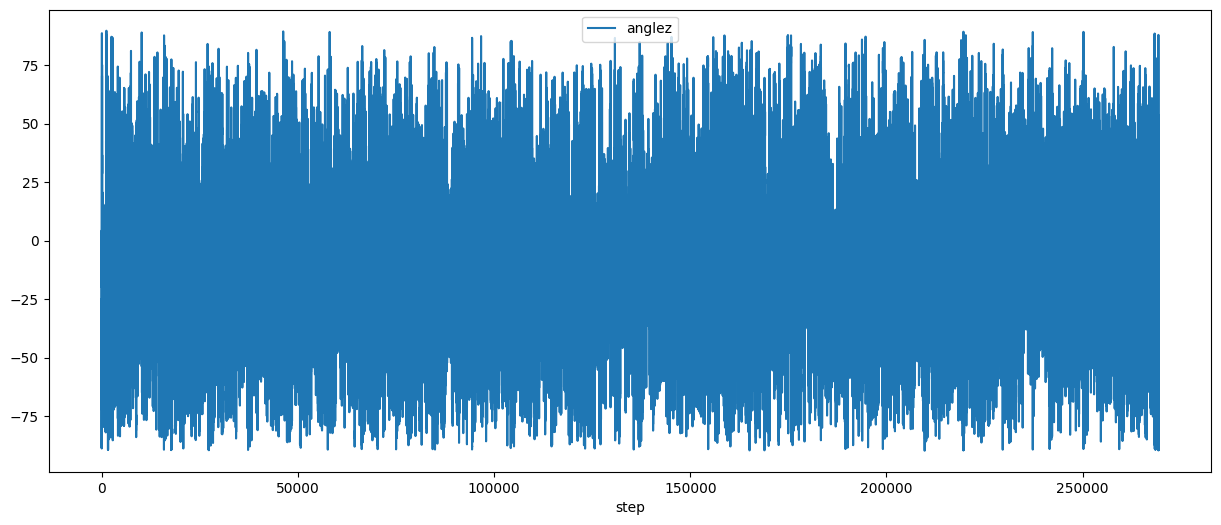

In [58]:
test.plot.line(x='step', y='anglez',figsize=(15, 6))
plt.show()
